Mount to my drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Imports

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as scs
import re
from numpy import genfromtxt
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, Conv2D,LSTM, BatchNormalization, MaxPooling1D, MaxPooling2D,Reshape, Permute
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from scipy import signal
import importlib

from os import walk
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
from matplotlib import cm

Load in training data

/content/drive/My Drive/GenshinImgs/Extract/Examples


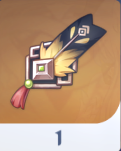

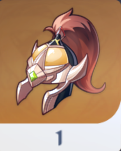

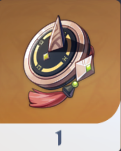

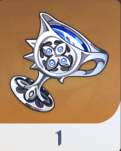

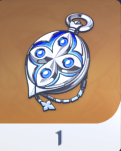

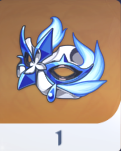

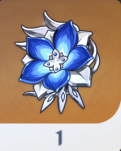

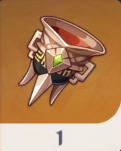

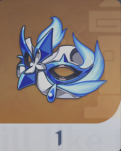

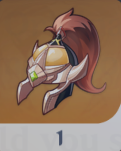

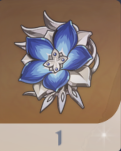

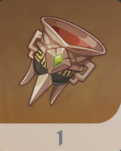

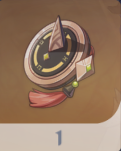

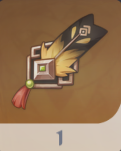

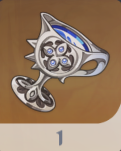

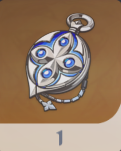

(16, 151, 121, 4)


In [ ]:

%cd '/content/drive/My Drive/GenshinImgs/Extract/Examples'
#get list of filenames
_, _, filenames = next(walk("./"))

X_train = []
X_num_train = []
flag=True
for f in filenames:
  with Image.open(f, 'r') as img:
    if(flag):
      W_test,H_test = img.size
      flag=False
    img = img.crop((0,0, W_test,H_test))
    display(img)
    num = img.crop((0,int(H_test*12.5/15), W_test,int(H_test)))  
    X_train.append(np.array(img))
    X_num_train.append(np.array(num))

H,W = (X_train[1].shape[0:2])
X_train = np.array(X_train)
X_num_train = np.array(X_num_train)
print(X_train.shape)

Same but for Test data

In [ ]:
%cd '/content/drive/My Drive/GenshinImgs/Extract/Batch 1/5Star'
#get list of filenames
_, _, filenames = next(walk("./"))

X_test = []
X_num_test = []
flag=True
i=0
for f in filenames:
  if i>100:
    break
  else:
    i+=1
  with Image.open(f, 'r') as img:
    if(flag):
      W_test,H_test = img.size
      flag=False
    img = img.crop((0,0, W_test,H_test))
    num = img.crop((0,int(H_test*12.5/15), W_test,int(H_test)))  
    X_test.append(np.array(img))
    X_num_test.append(np.array(num))

H,W = (X_train[1].shape[0:2])
X_test=np.array(X_test)
X_num_test=np.array(X_num_test)

/content/drive/My Drive/GenshinImgs/Extract/Batch 1/5Star


Assign labels to training data

In [ ]:
Num_range=8 #at 8 for now since that is all I have
y_train = np.array([0,1,2,3,4,5,6,7,5,1,6,7,2,0,3,4])
y_train = keras.utils.to_categorical(y_train, Num_range)  

print(y_train)

code={0:"TFe",1:"TC",2:"TH",3:"PG",4:"PH",5:"PC",6:"PFl",7:"TG"}#dictionary for what piece each num goes to

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]]


Create model

In [ ]:
# Model parameters
dropout = 0.90
lr = 1e-2
epochs = 200


#Building the model

cnn_models = []
for i in range(1):
  cnn_models.append(Sequential())
i=0;
# First block of conv.
cnn_models[i].add(Conv2D(filters=16, kernel_size=(1,1), input_shape=(H,W,4), activation='relu'))
cnn_models[i].add(MaxPooling2D(pool_size=(2,2), padding='same'))
cnn_models[i].add(BatchNormalization())
# cnn_models[i].add(Dropout(dropout))

# # Second block of conv.
cnn_models[i].add(Conv2D(filters=8, kernel_size=(2,2), activation='relu'))
cnn_models[i].add(MaxPooling2D(pool_size=(3,3), padding='same'))
cnn_models[i].add(BatchNormalization())
# cnn_models[i].add(Dropout(dropout))


# FC layer
cnn_models[i].add(Flatten())
cnn_models[i].add(Dense(Num_range, activation='softmax'))




  # Defining the optimizer
  # optimizer = keras.optimizers.Adam(learning_rate=lr)
optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
  
  # checkpoint_filepath = "/content/drive/Shareddrives/EE147/cnn_checkpoint/paperCNN"
  # # checkpoint = keras.callbacks.ModelCheckpoint(
  # #       #checkpoint_filepath,
  # #       monitor="val_accuracy",
  # #       save_best_only=True,
  # #       save_weights_only=True,)
  
lr_decay = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=8, verbose=False)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', verbose=False, patience=64)

callbacks=[lr_decay, early_stopping]

# Compiling the model
cnn_models[i].compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

cnn_models[i].summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 151, 121, 16)      80        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 76, 61, 16)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 76, 61, 16)        64        
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 75, 60, 8)         520       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 25, 20, 8)         0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 25, 20, 8)         32        
_________________________________________________________________
flatten_10 (Flatten)         (None, 4000)            

Train model

In [ ]:

cnn_results = cnn_models[0].fit(X_train,
                            y_train,
                            batch_size=32,
                            epochs=epochs,
                            callbacks=callbacks,
                            validation_data=(X_train, y_train), verbose=False)

score = cnn_models[0].evaluate(X_train, y_train, verbose=0)[1]
print(f'Test accuracy of the CNN model:',score)

Test accuracy of the CNN model: 1.0


Test the model

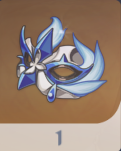

PC


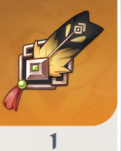

TF


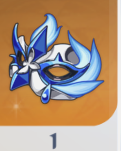

PC


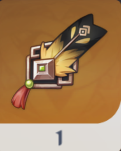

TF


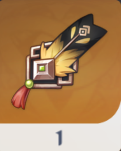

TF


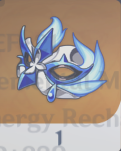

PC


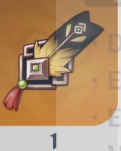

TF


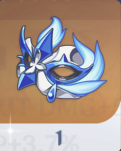

PC


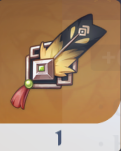

TF


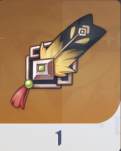

TF


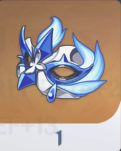

PC


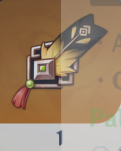

TF


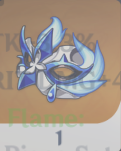

PC


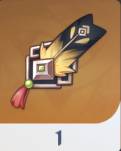

TF


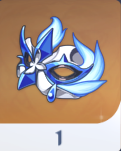

PC


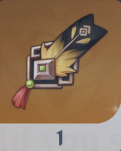

TF


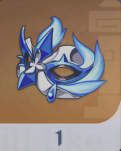

PC


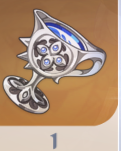

PG


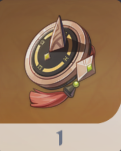

TH


In [ ]:
y_guess = cnn_models[0].predict(X_test)
for i in range(1,20):
  display(Image.fromarray(X_test[i]))
  print(code[np.argmax(y_guess[i])])

these 20 were all guessed correctly

Stuff that is now irrelevant 

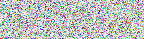

In [ ]:
np_im=np.random.rand(H,W,4)
np_im*=255
im2 = Image.fromarray(np.uint8(np_im)).convert('RGBA')
display(im2)


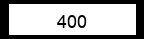

In [ ]:
img = Image.new('RGB', (100, 30), color = "grey")
 
d = ImageDraw.Draw(img)
d.text((30,10), "111111111111", fill="black")
#img.save("")

msg="400"
font = ImageFont.truetype("../arial.ttf", 18)
im = Image.new("RGBA",(W,H),color = "black")
draw = ImageDraw.Draw(im)
w, h = draw.textsize(msg, font=font)
points=[(int(W*1/16),int(H*1/8)),(int(W*15/16),int(H*1/8)),(int(W*15/16),int(H*7/8)),(int(W*1/16),int(H*7/8))]
draw.polygon(points, fill="white")
draw.text(((W-w)/2,(H-h)/2), msg, font=font, fill="black", spacing=1)
display(im)

X=[]
X_im=[]
y_raw=[]
num_train=500
Noise_mag=min(W,H)/8
fonts=["../arial.ttf","../GADUGIB.TTF", "../BAHNSCHRIFT.TTF"]
for i in range(1,Num_range):
  for j in range(num_train):
    noise=np.random.rand(12)
    noise*=Noise_mag

    msg=str(i)
    font = ImageFont.truetype(fonts[int(np.random.rand()*3)], int(18+(noise[10]-.5)*2))
    np_im=np.random.rand(H,W,4)
    np_im*=255
    im = Image.fromarray(np.uint8(np_im)).convert('RGBA')
    draw = ImageDraw.Draw(im)
    w, h = draw.textsize(msg, font=font)
    points=[(int(W*1/16+noise[0]),int(H*1/8+noise[1])),(int(W*15/16+noise[2]),int(H*1/8+noise[3])),(int(W*15/16+noise[4]),int(H*7/8+noise[5])),(int(W*1/16+noise[6]),int(H*7/8+noise[7]))]
    draw.polygon(points, fill="white")
    draw.text((int(noise[8]+(W-w)/2),int(noise[9]+(H-h)/2)), msg, font=font, fill="black", spacing=1)

    X_im.append(im)
    X.append(np.array(im))
    y_raw.append(i)



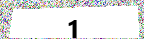

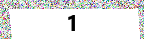

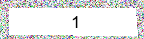

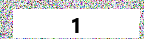

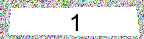

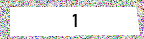

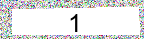

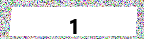

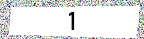

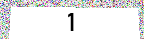

In [ ]:
for i in range(10):
  display(X_im[i])


In [ ]:
X=np.array(X)
y_raw=np.array(y_raw)
print(y_raw.shape)
y = keras.utils.to_categorical(y_raw,9)
print(X.shape)
print(y.shape)
print(y[::500])

B,H,W,D=X.shape

(4000,)
(4000, 39, 144, 4)
(4000, 9)
[[0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]
